<a href="https://colab.research.google.com/github/rklepov/hse-cs-ml-2018-2019/blob/homework/09-NLP/HW/hw2/nlp_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [*HW_texts*](https://github.com/rklepov/hse-cs-ml-2018-2019/blob/homework/09-NLP/HW/HW_texts.ipynb "HW_texts.ipynb") / Задание 1

---


In [1]:
!pip install pymorphy2

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
import os
import pickle

from joblib import Parallel, delayed
from tqdm import tqdm_notebook

In [4]:
import string
import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import WhitespaceTokenizer, TweetTokenizer
from nltk.stem.snowball import SnowballStemmer

import pymorphy2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Предобработка

### Загрузка данных твиттера

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
!ls -hl data/

total 2.6G
-rw------- 1 root root  24M Sep 22 12:24 negative.csv
-rw------- 1 root root  26M Sep 22 12:24 positive.csv
-rw------- 1 root root 893M Sep 22 12:24 ria_news_2018.pickle
-rw------- 1 root root 1.2G Sep 22 12:24 ria_vk_comments
-rw------- 1 root root  11M Sep 22 12:24 ria_vk_posts
-rw------- 1 root root  25M Sep 22 12:24 twitter_corpus_lem.dump
-rw------- 1 root root  22M Sep 22 12:24 twitter_corpus_stem.dump
-rw------- 1 root root 472M Sep 22 12:24 vk_comments_corpus_stem.dump


In [7]:
tweets_neg = pd.read_csv('data/negative.csv', sep=';', header=-1)
tweets_pos = pd.read_csv('data/positive.csv', sep=';', header=-1)

tweets = tweets_pos[[3,4]].append(tweets_neg[[3,4]])
tweets.columns = ['text', 'target']
tweets.reset_index(drop=True, inplace=True)
tweets['target'] = tweets['target'].replace({-1:0})

print(tweets.shape)
tweets.head(200).tail(5)

(226834, 2)


,text,target
195,RT @olyaolyaTerp: Классно потанцевали сегодня ...,1
196,"@koortain @veshchij_oleg я так понял, что буду...",1
197,"@mindofaddict , регенерация в действии)) Анали...",1
198,"@Yulchik_ya мне говорили, что на труде залили...",1
199,Проводить встречи утром это прикольно — контра...,1


### Очистка текста

1.   Удаление пунктуации
2.   Приведение к нижнему регистру
3.   Токенизация
4.   Лемматизация (или стемминг)
5.   Удаление стоп-слов
6.   Удаление оставшихся слов из одной буквы
7.   Обратное соединение токенов в текст через пробел

Лемматизация с помощью [`pymorphy`](https://pymorphy2.readthedocs.io/en/latest/) занимает продолжительное время по сравнению со стеммингом. Поскольку по заданию в дальнейшем необходимо будет предобработать корпус из комментариев Вк объёмом 4 млн. элементов, то это становтся неприемлемо. К тому же, как показала практика, на данном корпусе Твиттера существенного прироста в качестве за счёт лемматизации по сравнению со стеммингом не наблюдается.

In [0]:
def make_punct_remover(pattern = r'[^\w]+'):
    regex = re.compile(pattern)
    return lambda text : regex.sub(' ', text)

def make_lemmatizer(lemmatizer = pymorphy2.MorphAnalyzer()):
    return lambda words : [ lemmatizer.normal_forms(w)[0] for w in words ]

def make_stemmer(stemmer = SnowballStemmer('russian')):
    return lambda words : [ stemmer.stem(w) for w in words ]

In [0]:
def make_prepare_text(punct_remover, tokenizer, lemmatizer, stopwords):
    def prepare_text(text):
        text = punct_remover(text)    
        words = tokenizer.tokenize(text.lower())
        words = lemmatizer(words)
        words = [ w for w in words if len(w) > 1 and w not in stopwords ]
        return ' '.join(words)
    return prepare_text

Не будем включать частицу *`'не'`* в русский список стоп-слов (она может влиять на тональность текста).

In [0]:
stop_words_ru = [ item for item in stopwords.words('russian') if item != 'не' ]
stop_words_en = stopwords.words('english') 

stop_words = frozenset(stop_words_ru + stop_words_en)

In [0]:
prepare_text = make_prepare_text(make_punct_remover(), TweetTokenizer(), make_stemmer(), stop_words)

Пример предобработки текста:

In [12]:
tweets['text'][15]

'@Jyliaalex смотри там случайно в аспирантуру не попади, наука никого до добра не доводила)'

In [13]:
prepare_text(tweets['text'][15])

'jyliaalex смотр случайн аспирантур не попад наук ник добр не довод'

### Предобработка всего корпуса текстов

In [0]:
def prepare_corpus(corpus, prepare_text, dump_path):
    if not os.path.exists(dump_path):
        corpus_prep = Parallel(n_jobs=-1)(delayed(prepare_text)(text) for text in tqdm_notebook(corpus))
        with open(dump_path, 'wb') as dump:
            pickle.dump(corpus_prep, dump)
    else:
        with open(dump_path, 'rb') as dump:
            corpus_prep = pickle.load(dump)
    return corpus_prep

twitter_corpus_stem = prepare_corpus(tweets['text'].get_values(), prepare_text, 'data/twitter_corpus_stem.dump')

In [15]:
len(twitter_corpus_stem)

226834

## Модели

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

[Библиотека визуализации](https://github.com/FUlyankin/hse_texts_do/blob/master/sem_2/visual/ppilif_visual.py "hse_texts_do/ppilif_visual.py at master · FUlyankin/hse_texts_do") от Филиппа `@Ppilif`:

In [0]:
import ppilif_visual as pp

Разделение на обучающую и тестовую выборки.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(twitter_corpus_stem, tweets['target'].get_values(), 
                                                    test_size=0.2, random_state=303)

len(X_train), len(X_test)

(181467, 45367)

### [TF-IDF](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html "sklearn.feature_extraction.text.TfidfVectorizer &#8212; scikit-learn documentation") + [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html "sklearn.linear_model.LogisticRegression &#8212; scikit-learn documentation")

In [0]:
model_tfidf = Pipeline([
            ('vectorizer', TfidfVectorizer(min_df=2, max_df=0.4)),
            ('classifier', LogisticRegression(C=1.))
        ])

model_tfidf.fit(X_train, y_train);

Порог: 0.4395577152301691
Принцип выбора порога: maxf
Процентов теста в бане:  59.05
lift: 1.41 

              precision    recall  f1-score   support

           0       0.79      0.66      0.72     22258
           1       0.72      0.83      0.77     23109

    accuracy                           0.75     45367
   macro avg       0.75      0.74      0.74     45367
weighted avg       0.75      0.75      0.74     45367



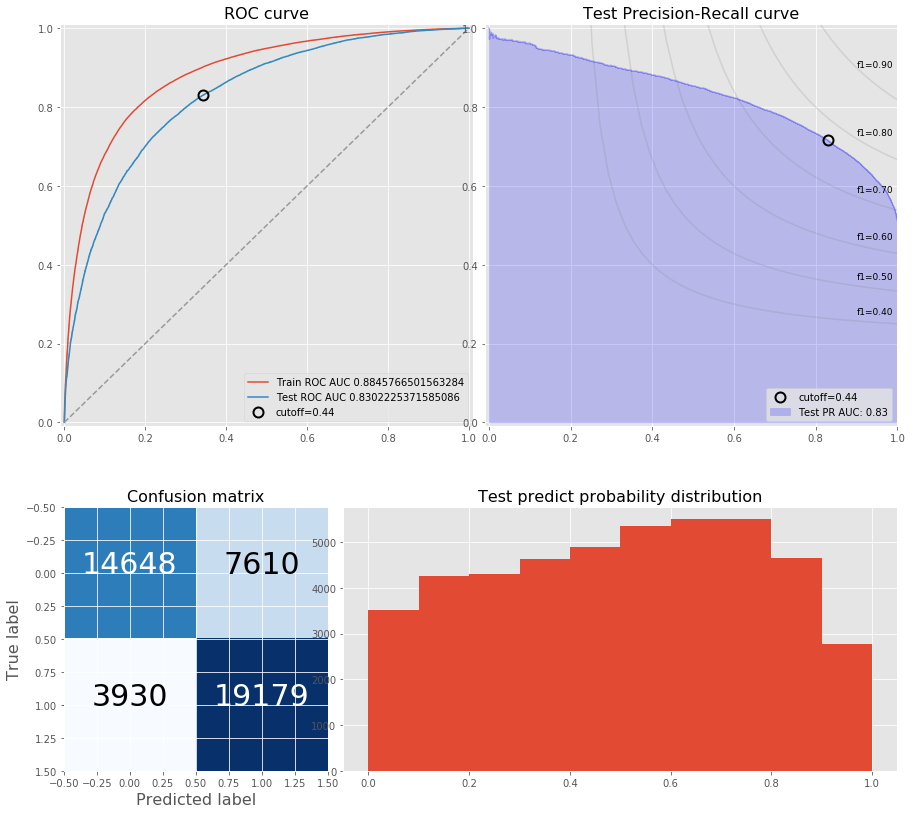

In [20]:
pp.classification_quality_report(model_tfidf, X_train, X_test, y_train, y_test)

### [Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html "sklearn.naive_bayes.MultinomialNB &#8212; scikit-learn documentation")

In [0]:
model_nb = Pipeline([
            ('vectorizer', CountVectorizer()),
            ('classifier', MultinomialNB())
        ])

model_nb.fit(X_train, y_train);

Порог: 0.2820096952099783
Принцип выбора порога: maxf
Процентов теста в бане:  61.55
lift: 1.37 

              precision    recall  f1-score   support

           0       0.79      0.62      0.70     22258
           1       0.70      0.84      0.76     23109

    accuracy                           0.73     45367
   macro avg       0.75      0.73      0.73     45367
weighted avg       0.74      0.73      0.73     45367



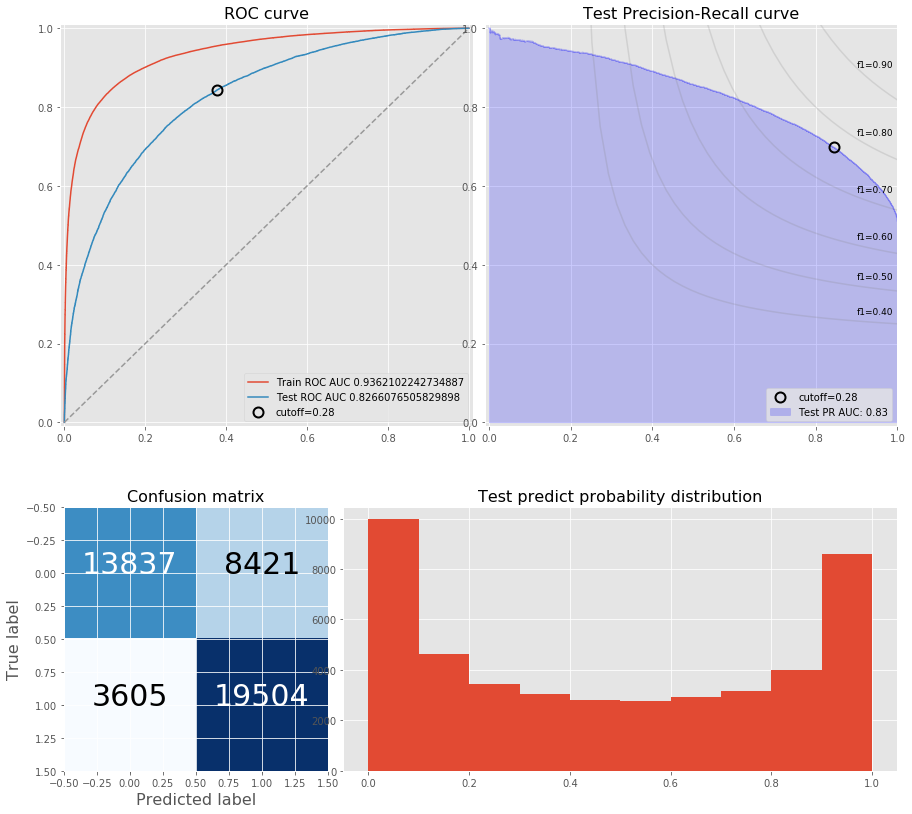

In [22]:
pp.classification_quality_report(model_nb, X_train, X_test, y_train, y_test)

### Сравнение

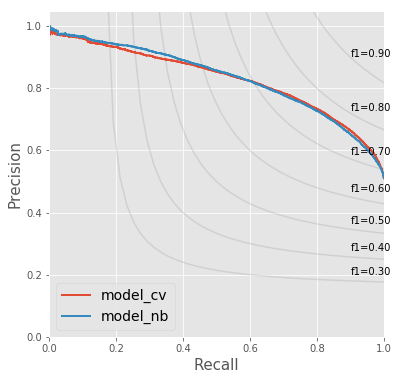

In [23]:
pp.plot_precision_recall_curve_many(
    y_test, figsize=(6 ,6),
    y_pred_probas=[model_tfidf.predict_proba(X_test)[:,-1],
                   model_nb.predict_proba(X_test)[:,-1]],
    labels=['model_cv', 'model_nb'])

## Комментарии ВК

In [24]:
with open('data/ria_vk_comments', 'rb') as f:
    vk_comments = pickle.load(f)

vk_comments = pd.DataFrame(vk_comments)

len(vk_comments)

4040551

In [25]:
vk_comments = vk_comments[['post_id', 'text']]

pd.set_option('max_colwidth', 200)

vk_comments.head(100500).tail(5)

,post_id,text
100495,23880215,Смысл таких новостей? Через месяц будет другой фаворит...
100496,23880215,"Какая вообще в них разница, люди ведь только звонят по телефону или Вайберу(Скайп и ТД) и играют в игры и всё))"
100497,23880215,"[id79102026|Никита], устарел да , но у меня все по сей день все функционирует и все доступно"
100498,23880215,"[id1022942|Илья], куда на лечение сдавать"
100499,23880215,"[id134235330|Павел], +79637777080 qiwi кошелек"


In [0]:
vk_comments_corpus_stem = prepare_corpus(vk_comments['text'].get_values(), prepare_text, 'data/vk_comments_corpus_stem.dump')

In [27]:
vk_comments_corpus_stem[:100500][-5:]

['смысл новост месяц друг фавор',
 'вообщ разниц люд вед тольк звон телефон ил вайбер скайп тд игра игр',
 'id79102026 никит устарел мен се ден функционир доступн',
 'id1022942 ил куд лечен сдава',
 'id134235330 павел 7963777708 qiw кошелек']

### Топ-10 негативных комментариев (*Naive Bayes*)

Попробуем предсказать тональность с помощью обученной ранее на Твиттере модели *Naive Bayes*.

In [28]:
vk_probas_nb = model_nb.predict_proba(vk_comments_corpus_stem)

vk_probas_nb.shape

(4040551, 2)

Предсказания для маленькой демонстрационной выборки выше:

In [29]:
model_nb.predict(vk_comments_corpus_stem[:100500][-5:])

array([1, 0, 0, 0, 1])

[Индексы](https://stackoverflow.com/a/23734295/10488248 "python - How do I get indices of N maximum values in a NumPy array? - Stack Overflow") 10 комментариев с наибольшей предсказанной вероятностью класса 0 (негатив):

In [30]:
vk_top10nb_neg_ix = np.argpartition(vk_probas_nb[:,0], -10)[-10:]

vk_top10nb_neg_ix = vk_top10nb_neg_ix[np.argsort(-vk_probas_nb[:,0][vk_top10nb_neg_ix])]

vk_probas_nb[:,0][vk_top10nb_neg_ix]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [31]:
pd.set_option('max_colwidth', 1000)

vk_comments.iloc[vk_top10nb_neg_ix][['text']]

,text
2529330,ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТЕ ТЕЛЕГУ!!!!ВЕРНИТ...
1176954,"[id16817481|Андрей], Последствия беременности и родов для женщины:\n\nПроблемы с зубами \nУвеличение размера ноги 50% Во время беременности вырабатывается гормон релаксин. Он ослабляет суставы таза, чтобы ребенок мог пройти по родовым путям. Этот гормон также ослабляет и связки в ступнях, из-за чего кости стопы расширяются. Сами кости ноги не растут, просто связки, удерживающие 26 костей стопы, становятся более расслабленными. \n\nВыпадение волос 50% Чаще всего волосы активно выпадают в течение примерно трех месяцев после родов. волоса.\nБоли в спине и суставах 50% Во время беременности и после родов позвоночник испытывает все более увеличивающиеся нагрузки. После родов нагрузки эти никуда не исчезают, пока ребенок не научится самостоятельно ходить. Если позвоночник оказался не готов к таким нагрузкам в нем происходят нарушения, причем чаще всего страдает поясничный отдел.\nНедержание мочи 38,6% рожавших женщин Непроизвольное выделение мочи(от пары капель до беспрерывного подтека..."
2524331,"[id375548449|Денис], ТТрассировка маршрута к equinix02-iad2.amazon.com [206.126.236.35] \nс максимальным числом прыжков 30: \n \n 1 2 ms 1 ms <1 мс Dlink-Router.Dlink [192.168.0.1] \n 2 1 ms 2 ms 2 ms 10.92.127.254 \n 3 1 ms 1 ms 1 ms lag-3-438.bgw01.tmn.ertelecom.ru [109.194.168.30] \n 4 * * * Превышен интервал ожидания для запроса. \n 5 * * * Превышен интервал ожидания для запроса. \n 6 * * * Превышен интервал ожидания для запроса. \n 7 * * * Превышен интервал ожидания для запроса. \n 8 * * * Превышен интервал ожидания для запроса. \n 9 * * * Превышен интервал ожидания для запроса. \n 10 * * * Превышен интервал ожидания для запроса. \n 11 * * * Превышен интервал ожидания для запроса. \n 12 * * * Превышен интервал ожидания для запроса. \n 13 * * * Превышен интервал ожидания для запроса. \n 14 * * * Превышен интервал ожидания для запроса. \n 15 * * * Превышен интервал ожидания для запроса. \n 16 * * * Превышен интервал ожидания для запроса. \n 17 * * * Превышен интервал ожидания дл..."
3630944,"[id53314634|Наташа], пьяного спасать не нужно ?? я домой шел под градусом после дня рождения друга, когда на меня напали 4 ублюдка и изрезали ножем вдоль и поперек, досмерти. даже не почуствовал, что режут меня, чувствовал только удары кувалдой, как это больно было. думал, что боксер бьет так сильно!!! я не алкаш и знаю пределы разумного употребляю в особых случаях. в тот момент после 11 ударов ножем я смог только 50 метров преодолеть и упал в холле магазина, даже не понял, что со мной случилось, сил на столько не было, что за эти 50 метров я упал раз 10, в магазин просто заполз!!! вам не понять, что такое геморрогический шок!!! когда приехала скорая, я им говорил, что сейчас отдышусь, встану, пойду дальше домой, вырубился! осознал, что со мной произошло через 3е суток. перебинтованный от подмышек до паха и с 3мя трубками торчащими из живота, груди и сидящим рядом хирургом!!! в общей сложности от поступления в больницу, до операции прошло 40 мин

### Топ-10 позитивных комментариев (*Logistic Regression*)

Для интереса также предсказание тональности с помощью обученной ранее на Твиттере логистической регрессии.

In [32]:
vk_probas_lr = model_tfidf.predict_proba(vk_comments_corpus_stem)

vk_probas_lr.shape

(4040551, 2)

In [33]:
vk_top10lr_pos_ix = np.argpartition(vk_probas_lr[:,1], -10)[-10:]

vk_top10lr_pos_ix = vk_top10lr_pos_ix[np.argsort(-vk_probas_lr[:,1][vk_top10lr_pos_ix])]

vk_probas_lr[:,1][vk_top10lr_pos_ix]

array([0.99995666, 0.99990503, 0.99950128, 0.99950128, 0.99919412,
       0.99846338, 0.99846338, 0.99846338, 0.99846338, 0.99794689])

In [34]:
list(vk_comments.iloc[vk_top10lr_pos_ix]['text'])

['Dd',
 'ахахах,борч:DDD',
 'iisus vosrkese epta :DDD',
 ':DDD',
 '[id109937745|Илья], :DDD',
 'Ахаха бльд ахахаха',
 'Ахаха. Ахахаха.',
 'ахаха ахахаха',
 'Ахахаха ахахах',
 'Ахаха ахахахаха ахахах']

## Статистика по комментариям

In [35]:
vk_comments['sentiment'] = np.argmax(vk_probas_nb, axis=1)

vk_comments.head()

,post_id,text,sentiment
0,24003681,"встану утром рано, выпью чашку ртути и пойду подохну в этом институте",0
1,24003681,Нет,1
2,24003681,"[id529161030|Утро], 👍🏻👍🏻👍🏻",1
3,24003681,Промахнулся ииии.......?😨,0
4,24003681,Это старая новость,0


### Количество негативных комментариев

Посчитаем количество негативных комментариев по новостям.

Поскольку позитивный комментарий закодирован **1**, а негативный - **0**, то число негативных комментариев можно вычислить с помощю стандартных функций агрегации:

In [0]:
vk_comments_stats = vk_comments.groupby('post_id')['sentiment'].agg(['count', 'sum'])
vk_comments_stats.columns = [ 'total', 'pos' ]
vk_comments_stats['neg'] = vk_comments_stats['total'] - vk_comments_stats['pos']

In [37]:
vk_comments_stats.head(3)

,total,pos,neg
post_id,,,
17976037,241,141,100
17976198,51,26,25
17976445,222,132,90


### Топ-5 негативно воспринятых новостей

 5 `post_id` новостей, которые пользователи восприняли наиболее отрицательно (среди тех, где есть хотябы 5 комментариев).

In [38]:
top_n = 5

topN_neg_comments = vk_comments_stats[vk_comments_stats['total'] > top_n] \
                        .nlargest(top_n, 'neg')

topN_neg_comments

,total,pos,neg
post_id,,,
21253718,1762,949,813
20204839,1474,706,768
21245320,1312,642,670
20429951,1103,435,668
22759381,1579,920,659


In [39]:
topN_neg_comments.index.to_list()

[21253718, 20204839, 21245320, 20429951, 22759381]

In [40]:
with open('data/ria_vk_posts', 'rb') as f:
    vk_news = pickle.load(f)

vk_news = pd.DataFrame(vk_news)

len(vk_news)

32277

Выберем негативные комментарии, добавим колонку с URL поста (его можно восстановить по *Id*-шникам), сконвертируем время (колонка `date`) в формат `datetime`: 

In [0]:
vk_news_topN_neg = vk_news[vk_news['id'].isin(topN_neg_comments.index.to_list())].copy()

vk_news_topN_neg['url'] = vk_news_topN_neg[['from_id', 'id']] \
    .astype(str) \
    .apply(lambda x: 'https://vk.com/ria?w=wall' + '_'.join(x), axis=1)

vk_news_topN_neg['date'] = pd.to_datetime(vk_news_topN_neg['date'], unit='s')

Присоединим таблицу с оценкой количества комментариев по тональности и отсортируем по числу негативных комментариев (по убыванию):

In [42]:
vk_news_topN_neg = vk_news_topN_neg[['id', 'date', 'comments', 'url', 'title', 'text']] \
    .set_index('id') \
    .join(topN_neg_comments.add_prefix('cmt_'), how='inner') \
    .sort_values(['cmt_neg'], ascending=False)

pd.set_option('max_colwidth', 200)

vk_news_topN_neg

,date,comments,url,title,text,cmt_total,cmt_pos,cmt_neg
21253718,2018-06-14 18:12:56,1761,https://vk.com/ria?w=wall-15755094_21253718,Правительство одобрило повышение пенсионного возраста и увеличение НДС,,1762,949,813
20204839,2018-03-27 16:24:12,1473,https://vk.com/ria?w=wall-15755094_20204839,NaN,,1474,706,768
21245320,2018-06-14 09:53:29,1311,https://vk.com/ria?w=wall-15755094_21245320,Правительство предложило повысить пенсионный возраст,Сейчас стандартный возраст выхода на пенсию в России — 60 и 55 лет у мужчин и женщин соответственно. Правительство предлагает поднять пенсионный возраст до 65 лет для мужчин и 63 для женщин.,1312,642,670
20429951,2018-04-12 09:31:51,1102,https://vk.com/ria?w=wall-15755094_20429951,NaN,В Кировской области подростки избили пожилого мужчину и сняли это на видео: https://ria.ru/incidents/20180412/1518457988.html,1103,435,668
22759381,2018-10-19 09:17:25,1578,https://vk.com/ria?w=wall-15755094_22759381,NaN,,1579,920,659


Как можно видеть, чисто интуитивно результат получился вполне адекватный (то есть, глядя на эти посты, вполне можно предположить, что они соберут много негативных комментариев).

Посты, для которых в таблице выше отсутствуют и заголовок, и текст, можно проверить по URL (в виде гиперссылок они вывдены ниже). 
*Примечание*: вторая ссылка не работает. Возможно, пост был удалён. Но по его дате можно предположить, что он имел отношение к пожару в Кемерово.

In [43]:
vk_news_topN_neg['url']

21253718    https://vk.com/ria?w=wall-15755094_21253718
20204839    https://vk.com/ria?w=wall-15755094_20204839
21245320    https://vk.com/ria?w=wall-15755094_21245320
20429951    https://vk.com/ria?w=wall-15755094_20429951
22759381    https://vk.com/ria?w=wall-15755094_22759381
Name: url, dtype: object

## Индекс негатива

In [0]:
search_pattern = 'путин'
rolling_window = 7

Найдём все посты, в заголовке или тексте которых есть заданное слово:

In [45]:
def match_news(news_df, search_pattern):
    return news_df['text'].str.lower().str.contains(search_pattern) | \
        news_df['title'].str.lower().str.contains(search_pattern)

vk_news_filtered = vk_news[match_news(vk_news, search_pattern)][['id', 'date', 'title', 'text']].set_index('id')

vk_news_filtered['date'] = pd.to_datetime(vk_news_filtered['date'], unit='s').dt.round(freq='D')

print(f'Количество постов: {len(vk_news_filtered)}')

vk_news_filtered.head()

Количество постов: 1381


,date,title,text
id,,,
23989576,2019-02-01,NaN,#ПРЯМАЯТРАНСЛЯЦИЯ \nВладимир Путин на встрече с предстоятелями православных церквей
23976154,2019-01-30,NaN,#ПРЯМАЯТРАНСЛЯЦИЯ \nВладимир Путин проводит встречу с членами правительства
23967188,2019-01-30,Захарову рассмешил предвыборный плакат Порошенко с Путиным,"Во время предвыборного форума президента Украины Петра Порошенко на экранах появилось изображение российского и украинского президентов с надписью: ""Либо Порошенко, либо Путин"". \n""А Путин в курсе..."
23942168,2019-01-28,Путин отодвинул охранника для рукопожатий с петербуржцами,
23941178,2019-01-28,"Путин заявил, что снятие блокады навсегда останется великим событием",


Присоединим число положительных/отрицательных комментариев для `post_id` и посчитаем скользящее среднее для заданного окна:

In [46]:
def add_rolling_mean(df, col, window):
    df['_'.join([col, 'roll' + str(window)])] = df[col].rolling(window).mean()
    return df

vk_news_neg_idx = vk_news_filtered \
    .join(vk_comments_stats.add_prefix('cmt_'), how='inner') \
    .groupby('date')['cmt_neg', 'cmt_pos'] \
    .sum() \
    .sort_index()

add_rolling_mean(vk_news_neg_idx, 'cmt_neg', rolling_window)
add_rolling_mean(vk_news_neg_idx, 'cmt_pos', rolling_window).tail()

,cmt_neg,cmt_pos,cmt_neg_roll7,cmt_pos_roll7
date,,,,
2019-01-25,47,58,119.43,228.43
2019-01-27,71,110,93.57,167.29
2019-01-28,268,436,108.57,184.86
2019-01-30,103,246,114.71,204.14
2019-02-01,110,224,126.57,223.57


Визуализируем индекс негатива:

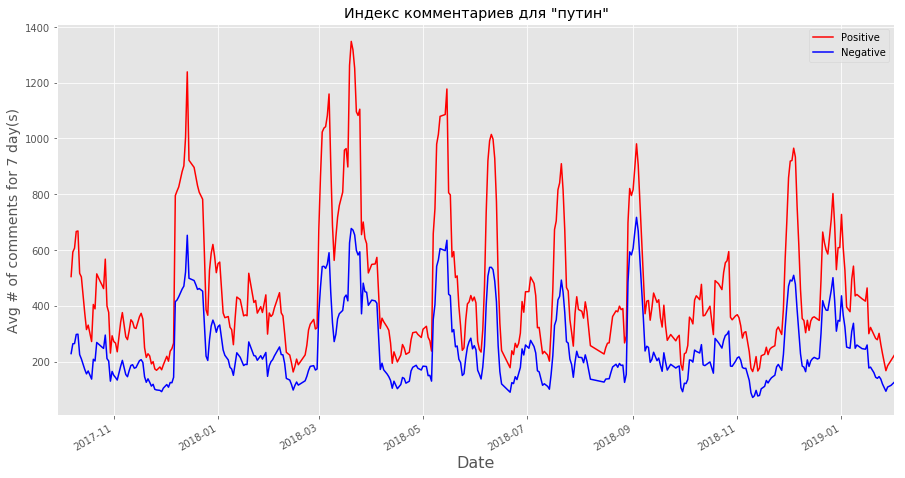

In [47]:
ax = vk_news_neg_idx[['cmt_pos_roll7', 'cmt_neg_roll7']].plot(figsize=(15, 8), color='rb')
ax.set_ylabel(f'Avg # of comments for {rolling_window} day(s)', fontsize=14)
ax.set_xlabel('Date', fontsize=16)
ax.set_title(f'Индекс комментариев для "{search_pattern}"')
ax.legend(['Positive', 'Negative']);